<h1><center> MACHINE LEARNING - PROJECT </center></h1>
<center> "WHAT ARE THE PEOPLE MORE LIKELY TO SURVIVE TO THE BOOLEAN PANDEMIC?"</center>

Notebook structure:
* [1. Sample](#sample)
    * [1.1. Import Libraries](#import)
    * [1.2. Import Datasets](#import2)
* [2. Explore](#explore)
    * [2.1. Data Exploration](#dataexplore)
    * [2.2. Missing Values Analysis](#miss_values)
    * [2.3. Outliers Analysis](#outliers)
* [3. Modify](#modify)
    * [3.1. Transform and Create variables](#transf_create)
    * [3.2. Coherence Checking](#coherence)
    * [3.3. Correlation analysis](#corr)
    * [3.4. Train Validation Partition](#train_val)
    * [3.5. Data Standardization](#datastand)
    * [3.6. Feature Selection](#feature)
        * [3.6.1. Lasso Regression](#lasso)
        * [3.6.2. Ridge Regression](#ridge)
        * [3.6.3. Recursive Feature Elimination (RFE)](#rfe)  
        * [3.6.4. Dimensionality Reduction](#dim_red) 
    * [3.7. Artificial Resampling](#unbalancedlearning)
        * [3.7.1. Random Oversampling](#randomoversampling)
        * [3.7.2. Synthetic Minority Oversampling Technique (SMOTE)](#smote)
        * [3.7.3. Adaptive Synthetic Oversampling (ADASYN)](#ADASYN)
        * [3.7.4. Cluster-Based Undersampling (K-Means)](#kmeansunder)
* [4. Model](#model)
    * [4.1. Model Exploration](#modelexp)
        * [4.1.1. K Nearest Neighbors](#knn)
        * [4.1.2. K Nearest Centroid](#knc)
        * [4.1.3. Random Forest](#rfc)
        * [4.1.4. Decision Tree](#dt)
        * [4.1.5. Passive Aggressive](#pa)
        * [4.1.6. Logistic Regression](#logreg)
        * [4.1.7. Multi-Layer Perceptron](#mlp)
        * [4.1.8. Naive Bayes](#naive)
        * [4.1.9. Support Vector Machine](#svm)
        * [4.1.10. Ensemble techniques](#ensemble)
            * [4.1.10.1. Balanced Bagging Classifier](#bbc)
            * [4.1.10.2. Gradient Boosting Classifier](#gbc)
            * [4.1.10.3. AdaBoost Classifier](#adaboost)
            * [4.1.10.4. Voting Classifier](#vc)
    * [4.2. Final Model](#finalmodel)

* [5. Assess](#assess)
* [6. Limitations](#limitations)
* [7. Conclusion](#conclusion)
<p style='text-align: right;'> Produced by: </p>
<p style='text-align: right;'> David Sousa (2016697) </p>
<p style='text-align: right;'> Miguel Ramos (2016728) </p>
<p style='text-align: right;'> Ricardo Florindo (2016727) </p>

<hr>
<a class="anchor" id="abs">
    
# Abstract
    
</a>

The aim of this project is to build a model capable of predicting if a patient will survive or not to a Boolean pandemic that had its origin in the state of New Mexico. For this purpose, a wide set of machine learning algorithms and grid search procedures were tested on the available data with the intent of finding the most relevant features and the best combination of data encoders and model hyperparameters. In the end, and as expected, the Multi-layer Perceptron algorithm was the one that provide the overall better results and, in some particular cases, the ensemble with the help of either the Vote Classifier or the Stacking Classifier also enhanced the final results. For the given data, and bearing in mind their limited size, the transformation or creation of new features often played a major role on the final accuracy of the model.

<hr>
<a class="anchor" id="sample">
    
# 1. Sample
    
</a>

In the first phase of our project, we have focus on importing the needed libraries and train and test datasets.


As for preprocessing our data we needed pandas and numpy. Consequently, to select variables, train our models and assess their results, we decided to mainly use sklearn classifiers and metrics.

Besides that, we also imported matplotlib and seaborn to plot data, methods from imblearn library not only to balanced our data classes, but also to run a Balanced Bagging ensemble Classifier. Finally, in order to obtain better results we also built a neural network from keras library.

<a class="anchor" id="import">

## 1.1. Import Libraries

</a>

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier, NearestCentroid, NeighborhoodComponentsAnalysis
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.impute import KNNImputer 
from sklearn.tree import DecisionTreeClassifier
from itertools import combinations_with_replacement
from imblearn.over_sampling import RandomOverSampler, SMOTE, KMeansSMOTE, ADASYN
from sklearn.linear_model import LinearRegression, LogisticRegression, LassoCV, RidgeCV, PassiveAggressiveClassifier
from keras import layers, models, regularizers
import keras
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from imblearn.ensemble import BalancedBaggingClassifier
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier, VotingClassifier, StackingClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, auc, roc_auc_score
from matplotlib.legend_handler import HandlerLine2D

Using TensorFlow backend.


<a class="anchor" id="import2">

## 1.2. Import Datasets

</a>

In [2]:
df = pd.read_csv(r'Data/train.csv')
test_df = pd.read_csv(r'Data/test.csv')

<hr>
<a class="anchor" id="explore">
    
# 2. Explore
    
</a>

In this step we are going to perform some initial analysis to our dataset, in order to understand the current state of our data. 

Since results are strongly dependent from the data, this is a crucial step to avoid “garbage in, garbage out”. Said that, in this section we want to minimize noisy information and, simultaneously, rise relevant and important information from our data. This procedure will be performed in two complementary steps: missing values treatment and outliers’ recognition.

<a class="anchor" id="dataexplore">

## 2.1. Data Exploration

</a>

In [3]:
df.shape

(900, 11)

In [4]:
df.head(5)

,Patient_ID,Family_Case_ID,Severity,Name,Birthday_year,Parents or siblings infected,Wife/Husband or children infected,Medical_Expenses_Family,Medical_Tent,City,Deceased
0,1,4696,3,Miss Linda Betty,NaN,0,0,225,NaN,Santa Fe,1
1,2,21436,1,Ms. Ramona Elvira,1966.0,0,1,1663,NaN,Albuquerque,0
2,3,7273,3,Mr. Mario Vernon,1982.0,0,0,221,NaN,Santa Fe,1
3,4,8226,3,Mr. Hector Joe,1997.0,0,0,220,NaN,Santa Fe,1
4,5,19689,3,Ms. Jennie Debra,1994.0,0,0,222,NaN,Santa Fe,0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 900 entries, 0 to 899
Data columns (total 11 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Patient_ID                         900 non-null    int64  
 1   Family_Case_ID                     900 non-null    int64  
 2   Severity                           900 non-null    int64  
 3   Name                               900 non-null    object 
 4   Birthday_year                      723 non-null    float64
 5   Parents or siblings infected       900 non-null    int64  
 6   Wife/Husband or children infected  900 non-null    int64  
 7   Medical_Expenses_Family            900 non-null    int64  
 8   Medical_Tent                       198 non-null    object 
 9   City                               898 non-null    object 
 10  Deceased                           900 non-null    int64  
dtypes: float64(1), int64(7), object(3)
memory usage: 77.5+ KB


In [6]:
df[['Severity', 'Birthday_year', 'Parents or siblings infected', 'Wife/Husband or children infected', 
    'Medical_Expenses_Family', 'Deceased']].describe()

,Severity,Birthday_year,Parents or siblings infected,Wife/Husband or children infected,Medical_Expenses_Family,Deceased
count,900.000000,723.000000,900.000000,900.000000,900.000000,900.000000
mean,2.313333,1990.266943,0.380000,0.521111,895.743333,0.614444
std,0.834223,14.523335,0.803247,1.098385,1385.829926,0.486997
min,1.000000,1940.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,1982.000000,0.000000,0.000000,221.000000,0.000000
50%,3.000000,1992.000000,0.000000,0.000000,405.000000,1.000000
75%,3.000000,1999.500000,0.000000,1.000000,861.250000,1.000000
max,3.000000,2019.000000,6.000000,8.000000,14345.000000,1.000000


In [7]:
df['Deceased'].value_counts(normalize=True)

1    0.614444
0    0.385556
Name: Deceased, dtype: float64

`NOTE:` Unbalanced learning, test over/under sampling.

<a class="anchor" id="miss_values">

## 2.2. Missing Values Analysis

</a>

Before starting any analysis, we must take a look to our dataset and ensure data quality. Therefore, we started by checking the existence of missing values as can be seen below. To properly deal with the 881 and 393 missing values present in the train and test dataset, respectively, it was necessary to adopt different approaches that would be suited for each case.

In [8]:
print("# of missing values by variable:")
df.isnull().sum()

# of missing values by variable:


Patient_ID                             0
Family_Case_ID                         0
Severity                               0
Name                                   0
Birthday_year                        177
Parents or siblings infected           0
Wife/Husband or children infected      0
Medical_Expenses_Family                0
Medical_Tent                         702
City                                   2
Deceased                               0
dtype: int64

In [9]:
print("# of missing values by variable:")
test_df.isnull().sum()

# of missing values by variable:


Patient_ID                             0
Family_Case_ID                         0
Severity                               0
Name                                   0
Birthday_year                         82
Parents or siblings infected           0
Wife/Husband or children infected      0
Medical_Expenses_Family                0
Medical_Tent                         311
City                                   0
dtype: int64

##### Medical Tent

In [10]:
df = df.drop(columns='Medical_Tent')
test_df = test_df.drop(columns='Medical_Tent')

In this particular case we decided to drop the variable "Medical Tent", once it as about 78% of missing values in respect to both training and testing data.

##### City

To fill the missing values in the variable "City", we decide to use the mode, since there are only two observations missing.

In [11]:
df.City.value_counts()

Santa Fe       649
Albuquerque    169
Taos            80
Name: City, dtype: int64

In [12]:
df['City'] = df['City'].fillna(df['City'].mode()[0])

In [13]:
df.City.value_counts()

Santa Fe       651
Albuquerque    169
Taos            80
Name: City, dtype: int64

##### Birthday Year

In what concerns the remaining missing values, all from the variable "Birthday Year", we decided to apply the K-Nearest Neighbor algorithm to fill them. This decision was based in the fact that there are 177 missing values, which we consider too much for applying a simple input (such as mean or median input), but not that many to remove a variable that we believe that might have some importance in our model. 
Later, with more knowledge of the dataset we might consider remove it.

In [14]:
# Training set
knn_vars = df.drop(['Patient_ID', 'Name', 'City', 'Deceased'], axis = 1)
imputer = KNNImputer(n_neighbors=10)
X_filled_knn = imputer.fit_transform(knn_vars)
years = np.round(X_filled_knn[:,2])

for i in range(len(knn_vars)):
    if knn_vars.loc[i,'Birthday_year'] < 1900:
        print (years[i])
        
df['Birthday_year'] = years

# Test set
knn_vars_test = test_df.drop(['Patient_ID', 'Name', 'City'], axis = 1)
imputer = KNNImputer(n_neighbors=10)
Xtest_filled_knn = imputer.fit_transform(knn_vars_test)
years_df = np.round(Xtest_filled_knn[:,2])
test_df['Birthday_year'] = years_df

<a class="anchor" id="outliers">

## 2.3. Outliers Analysis

</a>

In this step, we identified outliers through boxplot and histogram visualizations, where we compare odd values against the pattern of the data.

By looking at the boxplot, observations outside the minimum and maximum values, which is defined by the whis parameter, may be considered outliers. Despite that, is important to define the moment to stop cutting, otherwise we may take off non-outliers observations, so we identified the biggest distances in the extremes. This method requires a strong knowledge of our dataset and therefore we may need to perform some adjustments to this step later.

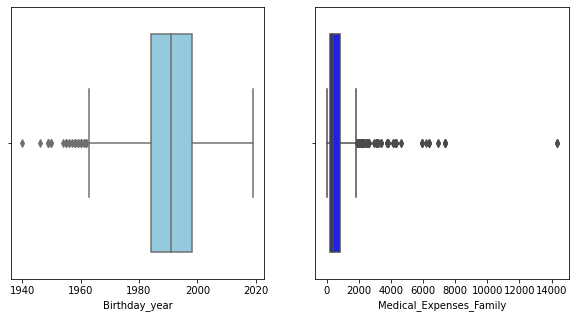

In [15]:
f, axes = plt.subplots(1,2, figsize=(10, 5), squeeze=False)    
sns.boxplot(df["Birthday_year"], color="skyblue", ax=axes[0, 0])
sns.boxplot(df["Medical_Expenses_Family"], color="blue", ax=axes[0, 1])

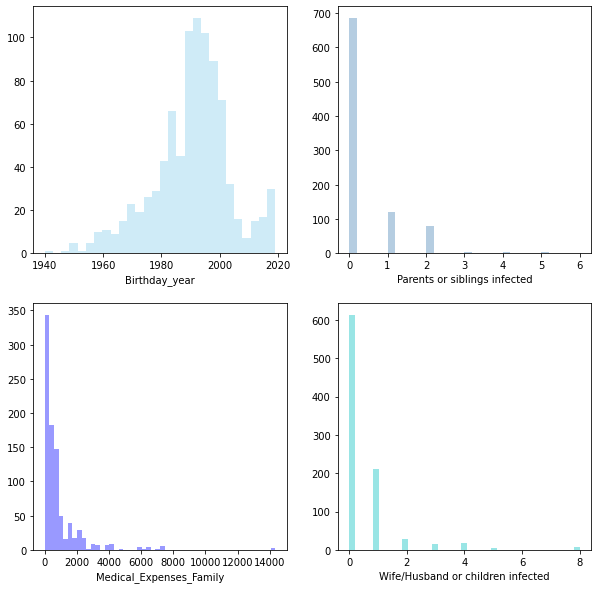

In [16]:
f, axes = plt.subplots(2, 2, figsize=(10, 10))
sns.distplot(df["Birthday_year"], color="skyblue", ax=axes[0, 0], kde=False)
sns.distplot(df["Parents or siblings infected"], color="steelblue", ax=axes[0, 1], kde=False)
sns.distplot(df["Medical_Expenses_Family"], color="blue", ax=axes[1, 0], kde=False)
sns.distplot(df["Wife/Husband or children infected"], color="c", ax=axes[1, 1], kde=False)

In [17]:
df['Outlier'] = 0
df.loc[df['Medical_Expenses_Family']>13000, 'Outlier']=1
df['Outlier'].value_counts()

0    897
1      3
Name: Outlier, dtype: int64

In [18]:
df = df.loc[df['Outlier'] == 0]

<hr>
<a class="anchor" id="modify">

# 3. Modify
    
</a>

The main purpose of this procedure is to prepare our dataset for the next phase, where we train our model.

Following this idea, we transformed and created variables, as well as checked incoherent observations. Besides that, we have partitioned our model into train set (70%) and validation set (30%), standardized both sets, and evaluate the importance of our variables in the model. 
For this evaluation some different approaches were taken into account. In a first phase, we performed correlation analysis, and later, some different methods were implemented, such as Lasso Regression and  Recursive Feature Elimination (RFE) in order to identify the most important variables.

Finally, since we noticed that our target variable were imbalanced, we considered that it may be useful to perform artificial resampling.

<hr>
<a class="anchor" id="transf_create">

## 3.1. Transform and Create Variables
    
</a>

At this point, we transformed the following variables:

- The nominal variable, City, was transformed into 2 dummy variables (since it has 3 classes), 'Santa Fe' and 'Taos'. Comprehensively, if one patient is from one of this cities it will have the value 1 in the respective variable, otherwise, if one patient is from Albuquerque he/she will have the value 0 in both classes;

- The other categorical variable, Name, was also transformed in a way of retaining the only useful information we can extract from it, which is the gender of the patients. In this way, if the Name was introduced by "Mr." or "Master" the new variable Male will have the value 1, otherwise it will be 0;

- In order to gain some interpretability, the variable 'Age' was created based on the difference between the birthday year and 2020;

- With the objective of increasing the score of our models some functional forms of the variable medical_expenses_family were made, such has the square, the logaritmic and a combination with the variable severity.
   
   



After this, some variables were also created based on the ones already existent:

- The number of family cases which is the sum of the all the cases of infection in the family (parents, children, wife/husband or children);
    
- The number of family elements (or a proxys of it, since not all the family elements are necessarily in the database), named 'Family Size', which had the main purpose of being used in the creation of other variables, such as the 'ProportionCases', that we consider important since it gave us an idea of the proportion of members infected in the family, in opposition of the previous variable, 'Family Cases' that only has data about the absolute number;
     
- Besides that, the number of 'Family Cases' also contributes to the creation of 'Medical_Expenses_Person', which informs about the number of expenses per family element;
        
- Finally, with the unique aim of obtaining better results, we consider that it might be more important to distinguish, not the number of a patient family members infected, but whether there are any wife/husband or children in the family infected, any parents or children infected or, even, if there are any member in the family infected. To do so, three binary variables were created, namely, 'WifeOrChildren_infected_bin', 'Parents_infected_bin' and 'Family_Infected_bin', respectively.



At the end of this step the following variables were deleted since they were either transformed into new variables or do not have relevant information to be used on the models, such as 'City','Name','Family_Case_ID','Birthday_year'.
The variable 'Patient_ID' which corresponds to the unique identifier of each patient and, for that won't be deleted, but neither will be used to train the models.

In [19]:
# TRANSFORM VARIABLES

# Santa Fe
df.loc[df['City'] == 'Santa Fe', 'Santa Fe'] = 1
df.loc[df['City'] != 'Santa Fe', 'Santa Fe'] = 0
test_df.loc[test_df['City'] == 'Santa Fe', 'Santa Fe'] = 1
test_df.loc[test_df['City'] != 'Santa Fe', 'Santa Fe'] = 0
# Taos
df.loc[df['City'] == 'Taos', 'Taos'] = 1
df.loc[df['City'] != 'Taos', 'Taos'] = 0
test_df.loc[test_df['City'] == 'Taos', 'Taos'] = 1
test_df.loc[test_df['City'] != 'Taos', 'Taos'] = 0

# Male
df['Male'] = '0'
test_df['Male'] = '0'
df.loc[df['Name'].str.startswith("Mr."), "Male" ] = "1"
df.loc[df['Name'].str.startswith("Master"), "Male" ] = "1"
test_df.loc[test_df['Name'].str.startswith("Mr."), "Male" ] = "1"
test_df.loc[test_df['Name'].str.startswith("Master"), "Male" ] = "1"

# Age
df['Age'] = 2020 - df['Birthday_year']
test_df['Age'] = 2020 - test_df['Birthday_year']

# ln_expenses_family
df['ln_expenses_family'] = np.log(df.Medical_Expenses_Family, where=(df.Medical_Expenses_Family!=0))
test_df['ln_expenses_family'] = np.log(test_df.Medical_Expenses_Family, where=(test_df.Medical_Expenses_Family!=0))

# square_expenses_family
df['Expenses_Family2'] = np.square(df.Medical_Expenses_Family)
test_df['Expenses_Family2'] = np.square(test_df.Medical_Expenses_Family)

# Severity_Expenses
df['Severity_Expenses'] = 0
df.loc[df['Medical_Expenses_Family']!=0, "Severity_Expenses"] = df.Severity * (1 / df.Medical_Expenses_Family)
test_df['Severity_Expenses'] = 0
test_df.loc[test_df['Medical_Expenses_Family']!=0, "Severity_Expenses"] = test_df['Severity'] * (1 / test_df['Medical_Expenses_Family'])


# CREATE VARIABLES

# Family_cases
df['Family_cases'] = df['Parents or siblings infected'] + df['Wife/Husband or children infected']
test_df['Family_cases'] = test_df['Parents or siblings infected'] + test_df['Wife/Husband or children infected']

# Family_size
Family_size = pd.DataFrame(df['Patient_ID'].groupby(df['Family_Case_ID']).count())
Family_size = Family_size.rename({'Patient_ID':'Family_size'}, axis='columns') 
df = df.merge(Family_size, on = ['Family_Case_ID'])

Family_size_test = pd.DataFrame(test_df['Patient_ID'].groupby(test_df['Family_Case_ID']).count())
Family_size_test = Family_size_test.rename({'Patient_ID':'Family_size'}, axis='columns') 
test_df = test_df.merge(Family_size_test, on = ['Family_Case_ID'])

# ProportionCases
df['ProportionCases'] = df['Family_cases'] / df['Family_size']
test_df['ProportionCases'] = test_df['Family_cases'] / test_df['Family_size']

# Medical_Expenses_Person
df['Medical_Expenses_Person'] = df['Medical_Expenses_Family']/df['Family_size']
test_df['Medical_Expenses_Person'] = test_df['Medical_Expenses_Family']/test_df['Family_size']

# Parents_infected_bin
df['Parents_infected_bin'] = 0
df.loc[df['Parents or siblings infected'] != 0, 'Parents_infected_bin'] = 1
test_df['Parents_infected_bin'] = 0
test_df.loc[test_df['Parents or siblings infected'] != 0, 'Parents_infected_bin'] = 1

# WifeOrChildren_infected_bin
df['WifeOrChildren_infected_bin'] = 0
df.loc[df['Wife/Husband or children infected'] != 0, 'WifeOrChildren_infected_bin'] = 1
test_df['WifeOrChildren_infected_bin'] = 0
test_df.loc[test_df['Wife/Husband or children infected'] != 0, 'WifeOrChildren_infected_bin'] = 1

# Family_Infected_bin
df['Family_Infected_bin'] = 1
df.loc[(df['WifeOrChildren_infected_bin'] == 0) & (df['Parents_infected_bin'] == 0), 'Family_Infected_bin'] = 0


# DROP VARIABLES
df.drop(columns = ['City','Name','Outlier','Family_Case_ID','Birthday_year'], inplace = True)
test_df.drop(columns = ['City','Name','Family_Case_ID','Birthday_year'], inplace = True)


# SET INDEX
df.set_index('Patient_ID', inplace = True)
test_df.set_index('Patient_ID', inplace = True)

<hr>
<a class="anchor" id="coherence">

## 3.2. Coherence Checking
    
</a>

Due to the small number of initial variables, we were not to strict in terms of possible incoherences. Said that, a patient having less than zero or more than 120 years old or severity values being out of the interval 1-3 were considered incoherent. Nevertheless, there were no patients with these characteristics.

In [20]:
df2 = df.copy()
df2['Incoherent'] = 0
df2.loc[(df['Severity'] > 3) | (df2['Severity'] < 1), 'Incoherent'] = 1
df2.loc[(df['Age'] > 120) | (df2['Age'] < 0), 'Incoherent'] = 1
df2['Incoherent'].value_counts()

0    897
Name: Incoherent, dtype: int64

We concluded that there are no incoherent values in our dataset.

<hr>
<a class="anchor" id="corr">

## 3.3. Correlation Analysis
    
</a>

In order to check if there are two or more variables explaining the same or almost the same information, we performed the correlation analysis. 

Since a big part of the variables in our dataset are not continuous, and, after some exhaustive research, we conclude that the Spearman correlation should be choosen in detriment of Person method, once the first one performs better when analysing the correlation between two categorical variables or categorical and continuous variables.

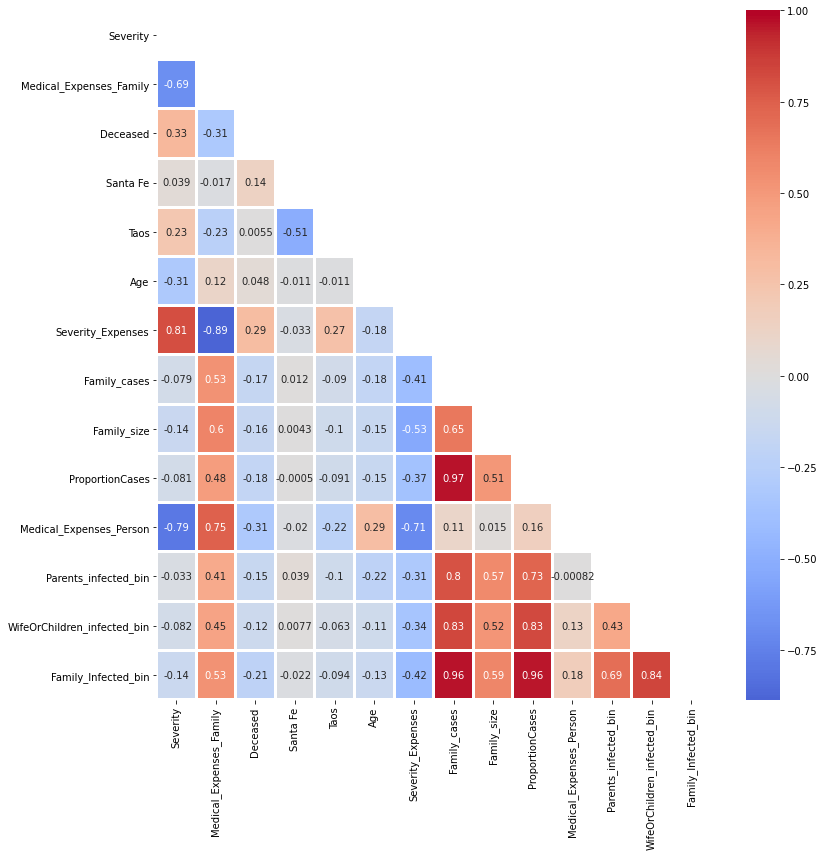

In [21]:
plt.rcParams['figure.figsize'] = (12,12)

corr_matrix=df.drop(columns=['Wife/Husband or children infected', 'Parents or siblings infected', 'ln_expenses_family', 'Expenses_Family2']).corr(method = 'spearman')
mask=np.zeros_like(corr_matrix, dtype=np.bool)
mask[np.triu_indices_from(mask)]=True
sns.heatmap(data=corr_matrix, mask=mask, center=0, annot=True, linewidths=2, cmap='coolwarm')
plt.tight_layout()

From the correlation analysis and based on the threshold of 0.8 in absolute value, many conclusions can be learned in what concerns feature selection, once this value suggest that those variables may retain the same information. As takeaways, from the visualization presented, these are the decisions to make:

- include the "Severity" or the transformation "Severity_Expenses";

- remove the variable "Family Cases" or one of the following variables: "WifeOrChildren_infected_bin", "Parents_infected_bin", "Family_Infected_bin" or the "ProportionCases" variable.

Besides that, there are some values that we should pay some attention, specially the ones related with the variable "Medical_Expenses_Person", which also seems to be strongly correlated with the "Medical expenses_family" (0.75) and the "Severity" (-0.79).


This was an iterative process in combination with feature selection section that will be introduced later.

<hr>
<a class="anchor" id="train_val">

## 3.4. Train Validation Partition
    
</a>

The train validation split provides the ability to train the model with a set of the data and validate its generalization capability independently in another set. Thus, the training set is used to learn and build the model, as a consequence, the estimate of the error will be optimistic since the model will be assessed in data it has already seen. On the other hand, the validation set is used to assess the performance of the model on unseen data and therefore provide an unbiased estimate of the error. 

From the hold-out approach, 30% of the data was used for validation, where the distribution of the dependent variable was maintained in both partitions.

Additionally, this process is highly dependent on feature selection once the results obtained determine what variables seem to be more relevant to explain the patient's death. Therefore, each time feature selection was accomplished we returned to this step in order to select the most appropriate features to the model.

In [22]:
variables = ['Severity', 'Age', 'Male', 'Santa Fe', 'Family_cases', 'Parents_infected_bin']
# variables = ['Severity', 'Age', 'Male', 'Santa Fe', 'Family_cases', 'Parents_infected_bin',
#              'square_expenses_family']  # for version 38

X = df[variables]

y = df['Deceased']

In [23]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, 
                                                  random_state=15, shuffle=True, stratify=y)

<hr>
<a class="anchor" id="datastand">

## 3.5. Data Standardization
    
</a>

Taking into consideration that variables are measured in different scales, their contribution to the model may not be equal. Therefore, data standardization allows different features to have the same impact on the model. 

Said that, several feature scaling techniques were tested, such as z-score (standard scaler), robust scaler and min-max normalization. As a result, z-score provided better results.

In [24]:
scaler = StandardScaler().fit(X_train)  # z-score
#scaler = RobustScaler().fit(X_train) # robust standardization

scaler_X_train = scaler.transform(X_train)
scaler_X_train = pd.DataFrame(scaler_X_train, columns=variables)

scaler_X_val = scaler.transform(X_val)
scaler_X_val = pd.DataFrame(scaler_X_val, columns=variables)

test_df = test_df[variables]
scaler_X_test = scaler.transform(test_df)
scaler_X_test = pd.DataFrame(scaler_X_test, columns=variables)

In [25]:
# min max normalization
##minmax = MinMaxScaler(feature_range=(-1,1)).fit(X_train)
#minmax = MinMaxScaler().fit(X_train)
#scaler_X_train = pd.DataFrame(minmax.transform(X_train))
#scaler_X_val = pd.DataFrame(minmax.transform(X_val))
#test_df = test_df[variables]
#scaler_X_test = pd.DataFrame(minmax.transform(test_df))

#scaler_X_train.columns = variables
#scaler_X_val.columns = variables
#scaler_X_test.columns = variables

<hr>
<a class="anchor" id="feature">

## 3.6. Feature Selection
    
</a>

Feature selection is the process of reducing the number of input variables. It is desirable to reduce the number of input variables, not only to improve the performance of the model, but also to reduce the computational cost of modeling.

In regards to improving the performance of the model, lasso, ridge regression and recursive feature elimination were implemented. Analyzing these approachs together helped to decide which variables allowed us to increase the score of our models.

Furthermore, Neighborhood Component Analysis dimensionality reduction technique, which aims to improve the accuracy of nearest neighbors classification compared to the standard Euclidean distance was implemented, however this approach did not improved the results obtained.

<hr>
<a class="anchor" id="lasso">

### 3.6.1. Lasso Regression
    
</a>

Lasso Regression is a type of linear regression frequently used in feature selection. The reason behind this process, relates with the fact that Lasso method puts a constraint on the sum of the absolute values of the model parameters, the sum has to be less than a fixed value. In order to do so, the method apply a shrinking (regularization) process where it penalizes the coefficients of the regression variables shrinking some of them to zero. A zero coefficient in Lasso Regression, normally implies that the respective variable has very few or no importance on the model.

In [26]:
def plot_importance(coef,name):
    imp_coef = coef.sort_values()
    plt.figure(figsize=(8,10))
    imp_coef.plot(kind = "barh")
    plt.title("Feature importance using " + name + " Model")
    plt.show()

In [27]:
reg = LassoCV()
reg.fit(scaler_X_train, y_train)
coef = pd.Series(reg.coef_, index=scaler_X_train.columns)
coef.sort_values()

Parents_infected_bin   -0.040170
Santa Fe                0.022012
Family_cases            0.060047
Age                     0.063361
Severity                0.140109
Male                    0.248872
dtype: float64

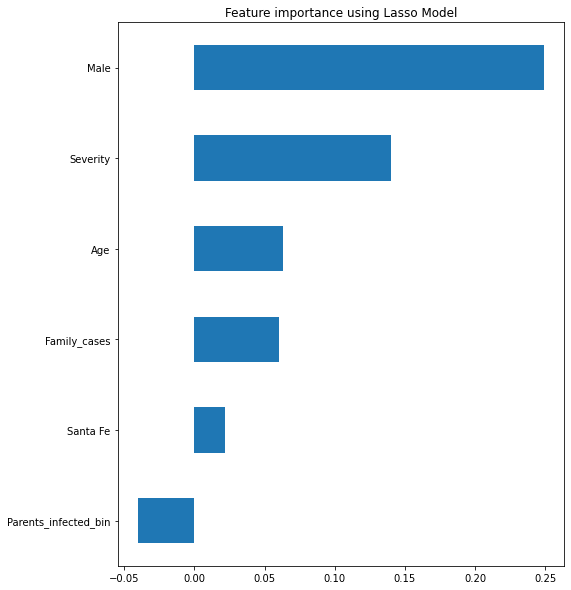

In [28]:
plot_importance(coef, 'Lasso')

<hr>
<a class="anchor" id="ridge">

### 3.6.2. Ridge Regression
    
</a>

Ridge Regression is also a type of linear regression, very similar to Lasso in the sense that it applies a shrinking process that penalizes the coefficients. The mainly difference is how this regularization is applied, since in Ridge the coefficients become very close to zero, but never zero. 

Consequently, the analysis of the results is done in a similar way of Lasso Regression, this is, variables with the highest coefficients are considered the most important ones, and vice versa.

In [29]:
ridge = RidgeCV()
ridge.fit(X=scaler_X_train, y=y_train)
coef_ridge = pd.Series(ridge.coef_, index=scaler_X_train.columns)
print(coef_ridge.sort_values())

Parents_infected_bin   -0.039750
Santa Fe                0.022564
Family_cases            0.058153
Age                     0.062268
Severity                0.138453
Male                    0.245311
dtype: float64


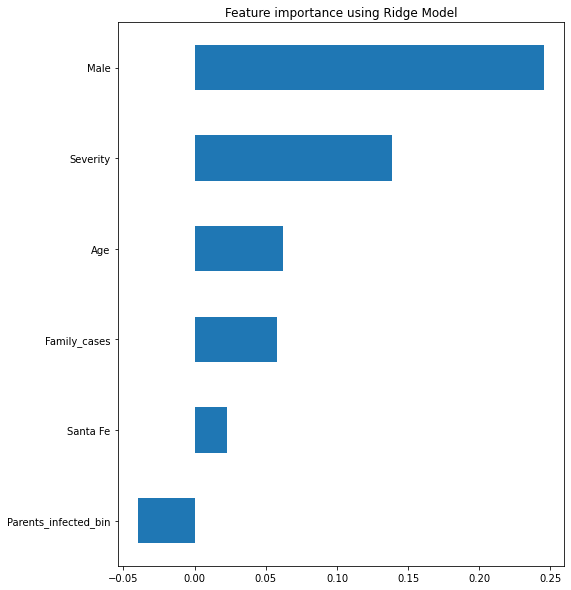

In [30]:
plot_importance(coef_ridge,'Ridge')

<hr>
<a class="anchor" id="rfe">

### 3.6.3. Recursive Feature Elimination (RFE)
    
</a>

The main objective of Recursive Feature Elimination (RFE) is to select features by recursively considering smaller and smaller sets of variables. 

At the beggining, the estimator is trained on the entire set of features and the importance of each feature is obtained either through the respective coefficient or through a ranking of the variable in comparison with the remaining ones. 
Then, the least important features are pruned from the current set of features. This procedure is recursively repeated on the pruned set until the desired number of features to select is eventually reached.

Smaller values in the ranking suggest higher importance on the model.

In [31]:
# nro of features
nof_list=np.arange(1,10)            
high_score=0
# Variable to store the optimum features
nof=0           
score_list =[]
for n in range(len(nof_list)):

    X_train_rfe, X_rfe_val, y_train_rfe, y_rfe_val = train_test_split(scaler_X_train, y_train, test_size = 0.2, 
                                                                      random_state = 15)
    
    model_rfe = LogisticRegression()
    rfe = RFE(model_rfe,nof_list[n])
    X_train_rfe = rfe.fit_transform(X_train_rfe,y_train_rfe)
    X_rfe_val = rfe.transform(X_rfe_val)
    
    model_rfe.fit(X_train_rfe,y_train_rfe)
    
    score = model_rfe.score(X_rfe_val,y_rfe_val)
    score_list.append(score)
    
    if(score>high_score):
        high_score = score
        nof = nof_list[n]
        

print("Optimum number of features: %d" %nof)
print("Score with %d features: %f" % (nof, high_score))

Optimum number of features: 1
Score with 1 features: 0.777778


In [32]:
N = 4
model_rfe = LogisticRegression()
rfe = RFE(estimator = model_rfe, n_features_to_select = N)
X_rfe = rfe.fit_transform(X = scaler_X_train, y = y_train) 

selected_features_rfe = pd.Series(rfe.ranking_, index = scaler_X_train.columns)
selected_features_rfe.sort_values()

Severity                1
Age                     1
Male                    1
Family_cases            1
Parents_infected_bin    2
Santa Fe                3
dtype: int64

<hr>
<a class="anchor" id="dim_red">

### 3.6.4. Dimensionality Reduction
    
</a>

The Dimensionality Reduction approach can be performed through multiple methods, such as Principal Components Analysis (PCA), Factor Analysis (FA) or Neighborhood Component Analysis (NCA). In this case, we decided to use NCA.

The dimensionality reduction performs in a different way compared to the remaining methods mentioned, since it combines the variables, instead of selecting them. NCA aims at learning a distance metric by finding a linear transformation of input data such that the average leave-one-out classification performance is maximized in the transformed space.

In [33]:
# Reduce dimension to 2 with Neighborhood Component Analysis
nca = NeighborhoodComponentsAnalysis(n_components=2, random_state=15).fit(scaler_X_train, y_train)

# Obtain X embedded
X_embedded_train = pd.DataFrame(nca.transform(scaler_X_train))
X_embedded_val = pd.DataFrame(nca.transform(scaler_X_val))
test_embedded = pd.DataFrame(nca.transform(scaler_X_test))

<hr>
<a class="anchor" id="unbalancedlearning">

## 3.7. Artificial Resampling
    
</a>

As previously mentioned, the distribution of the dependent variable is not completely balanced (0-39%; 1-61%), consequently in order to overcome this behavior artificial resampling was performed, where repeated samples of the original data were generated.

As a result, several oversampling and undersampling techniques were applied, as described below.

<hr>
<a class="anchor" id="randomoversampling">

### 3.7.1. Random Oversampling
    
</a>

Randomly Oversampling generates exact replicas of the minority class, i.e. create clones of employee based on the existing ones. As a consequence, this technique may lead to overfitting.

In [34]:
#weights = {0:300, 1:387}
#ros = RandomOverSampler(sampling_strategy=weights, random_state=15)
#X_res, y_res = ros.fit_resample(scaler_X_train, y_train)

<hr>
<a class="anchor" id="smote">

### 3.7.2. Synthetic Minority Oversampling Technique (SMOTE)
    
</a>

In Synthetic Minority Oversampling Technique (SMOTE), a subset of data is taken from the minority class as an example and then new synthetic similar instances are created. This technique mitigates the problem of overfitting caused by random oversampling, however it does not take into consideration neighboring examples from other classes, possibly resulting in increase overlapping of classes and therefore may introduce additional noise.

In [35]:
#weights = {0:300, 1:387}
#smote = SMOTE(sampling_strategy=weights, random_state=15)
#X_res, y_res = smote.fit_resample(scaler_X_train, y_train)

<hr>
<a class="anchor" id="ADASYN">

### 3.7.3. Adaptive Synthetic Oversampling (ADASYN)
    
</a>

Adaptive Synthetic Oversampling (ADASYN) is a similar approach compared to SMOTE but with a minor improvement, that is, after creating the synthetic similar instances, a random small value is added. In other words, instead of all the sample being linearly correlated to the parent they possess an additional variance component.

In [36]:
#weights = {0:300, 1:387}
#adasyn2 = ADASYN(sampling_strategy=weights, random_state=15)
#X_res, y_res = adasyn2.fit_resample(scaler_X_train, y_train)

<hr>
<a class="anchor" id="kmeansunder">

### 3.7.4. Cluster-Based Undersampling (K-Means)
    
</a>

K-means Undersampling keeps N majority samples by fitting K-means algorithm with N clusters to the majority class and using the coordinates of the N cluster medoids as the new majority samples.

In [37]:
#weights = {0:240, 1:300}
#cc = ClusterCentroids(sampling_strategy=weights, random_state=15)
#X_res10, y_res10 = cc.fit_resample(X_res, y_res)

After testing a substantial amount of variable combinations, resampling techniques and standardization procedures we came up with a set of preferable components for each of these categories. In the end, our model seems to obtain better results when using the standard scaler as standardization procedure, maintaining the original number of samples and using the following combination of variables: Severity, Age, Male, Santa Fe, Family_cases and Parents_infected_bin. 

Note that this does not mean that a model with this characteristics is the best possible model, this is merely an indication of the aspects that gave the best overall results in our particular case.

<hr>
<a class="anchor" id="model">

# 4. Model
    
</a>

<hr>
<a class="anchor" id="modelexp">

## 4.1 Model Exploration
    
</a>

In this section, we presented all the algorithms tested as well as the correspondent grid search.

The hyperparameters tuning was accomplished through the creation of a grid search with 5 fold stratified cross-validation with the objective to obtain robust results. The focus was to optimize the average *Accuracy*, that is, the number of correct predictions divided by the total number of input samples.

Through this methodology, several standardization techniques and combinations of variables were tested to reach the best possible results. Moreover, several classifiers were tested in combination with these representations, namely, K-Nearest Neighbors, K-Nearest Centroid, Decision Trees, Random Forest, Passive Agressive, Logistic Regression, Naive Bayes, Multi-Layer Perceptron, Neural Networks, Support Vector Machine and a wide variety of ensemble techniques.

<hr>
<a class="anchor" id="knn">

### 4.1.1. K Nearest Neighbors
    
</a>

In [38]:
k = 5
cv = StratifiedKFold(n_splits=k, shuffle=True, random_state=15)

In [39]:
# knn_clf = KNeighborsClassifier()

# knn_parameters = {'n_neighbors' : np.arange(1,31,1),
#                   'metric' : ['euclidean', 'cosine', 'manhattan', 'minkowski'],
#                   'weights' : ['uniform', 'distance'],
#                   'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']}

# knn_grid = GridSearchCV(estimator=knn_clf, param_grid=knn_parameters, cv=cv, scoring='accuracy', verbose=1, n_jobs=-1)

# knn_grid.fit(scaler_X_train, y_train)

# knn_grid.best_params_

In [40]:
knn = KNeighborsClassifier(algorithm='brute', metric='euclidean', n_neighbors=10, weights='uniform')
knn.fit(scaler_X_train, y_train)

KNeighborsClassifier(algorithm='brute', leaf_size=30, metric='euclidean',
                     metric_params=None, n_jobs=None, n_neighbors=10, p=2,
                     weights='uniform')

In [41]:
labels_train_knn = knn.predict(scaler_X_train)
accuracy_score(y_train, labels_train_knn)

0.8293460925039873

In [42]:
labels_val_knn = knn.predict(scaler_X_val)
accuracy_score(y_val, labels_val_knn)

0.7814814814814814

<hr>
<a class="anchor" id="knc">

### 4.1.2. K Nearest Centroid
    
</a>

In [43]:
# knc_clf = NearestCentroid()

# knc_parameters = {'metric' : ['euclidean', 'cosine', 'manhattan']}

# knc_grid = GridSearchCV(estimator=knc_clf, param_grid=knc_parameters, cv=cv, scoring='accuracy', verbose=1, n_jobs=-1)

# knc_grid.fit(scaler_X_train, y_train)

# knc_grid.best_params_

In [44]:
knc = NearestCentroid(metric='manhattan')
knc.fit(scaler_X_train, y_train)

NearestCentroid(metric='manhattan', shrink_threshold=None)

In [45]:
labels_train_nc = knc.predict(scaler_X_train)
accuracy_score(y_train, labels_train_nc)

0.8022328548644339

In [46]:
labels_val_nc = knc.predict(scaler_X_val)
accuracy_score(y_val, labels_val_nc)

0.7518518518518519

<hr>
<a class="anchor" id="rfc">

### 4.1.3. Random Forest
    
</a>

In [47]:
# rf_clf = RandomForestClassifier(class_weight='balanced', random_state=15)

# rf_parameters = {"n_estimators": np.arange(100, 400, 100),
#                  "max_features": ['sqrt', 'log2', 'auto', None],
#                  "criterion": ['gini', 'entropy'],
#                  "warm_start" : [True, False]}

# rf_grid = GridSearchCV(estimator=rf_clf, param_grid=rf_parameters, cv=cv, scoring='accuracy', verbose=1, n_jobs=-1)

# rf_grid.fit(X_train, y_train)
# rf_grid.best_params_

In [48]:
rf = RandomForestClassifier(ccp_alpha=0.004, class_weight={0: 1.1800000000000002, 1: 1.0300000000000002},
                       criterion='gini', n_estimators=45, random_state=15,
                       warm_start=True).fit(scaler_X_train, y_train)

In [49]:
labels_train_rf = rf.predict(scaler_X_train)
accuracy_score(y_train, labels_train_rf)

0.8564593301435407

In [50]:
labels_val_rf = rf.predict(scaler_X_val)
accuracy_score(y_val, labels_val_rf)

0.8111111111111111

<hr>
<a class="anchor" id="dt">

### 4.1.4. Decision Tree
    
</a>

In [51]:
def calculate_AUC(interval, x_train, x_test, y_train, y_test, parameter, max_depth = None):
    train_results = []
    test_results = []
    for value in interval:
        if (parameter == 'depth'):          
            dt = DecisionTreeClassifier(max_depth = value, random_state=15)
            dt.fit(x_train, y_train)
        elif (parameter == 'features'):  
            dt = DecisionTreeClassifier(max_features = value, max_depth = max_depth, random_state=15)
            dt.fit(x_train, y_train)
        train_pred = dt.predict(x_train)
        roc_auc_valuetrain = roc_auc_score(y_train, train_pred, average = None, multi_class='ovr')
        # Add auc score to previous train results
        train_results.append(roc_auc_valuetrain)
        
        y_pred = dt.predict(x_test)
        roc_auc_valuetest = roc_auc_score(y_test, y_pred, average='weighted', multi_class='ovr')
        # Add auc score to previous test results
        test_results.append(roc_auc_valuetest)
    value_train = train_results.index(max(train_results))
    value_test = test_results.index(max(test_results))
    print('The best train value is ',interval[value_train])
    print('The best validation value is ',interval[value_test])
    
    
    line1, = plt.plot(interval, train_results, 'b', label="Train AUC")
    line2, = plt.plot(interval, test_results, 'r', label="Val AUC")
    plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
    plt.ylabel("ROC AUC score")
    plt.xlabel(str(parameter))
    plt.show()

The best train value is  15.0
The best validation value is  3.0


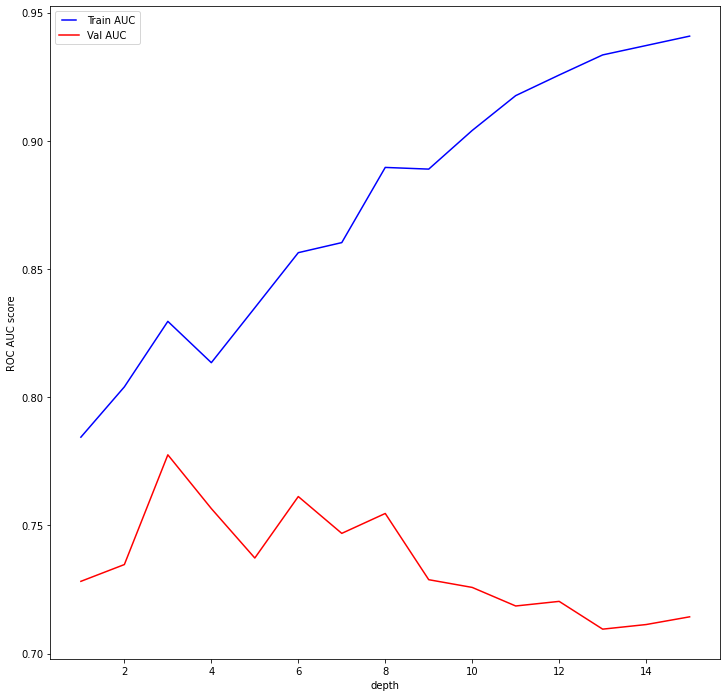

In [52]:
max_depths = np.linspace(1, 15, 15, endpoint=True)  
calculate_AUC(max_depths, scaler_X_train, scaler_X_val, y_train, y_val, 'depth')

The best train value is  5
The best validation value is  5


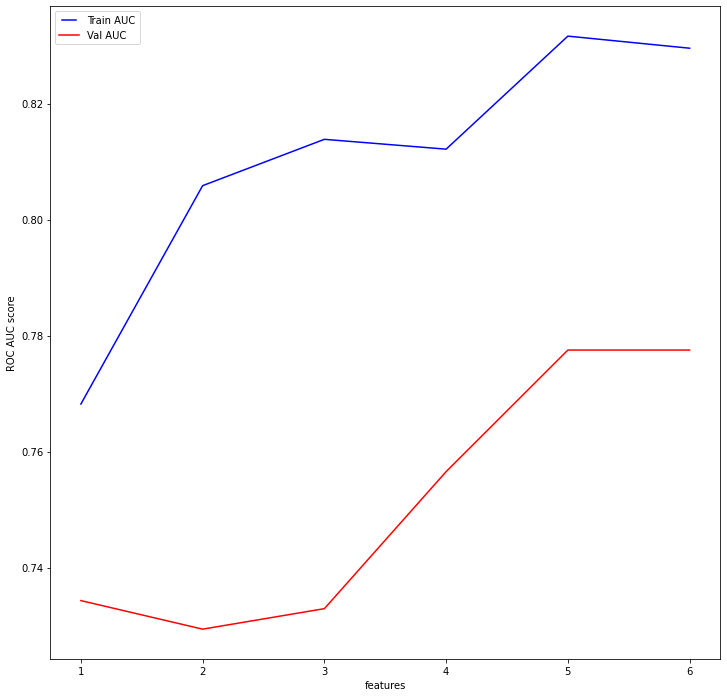

In [53]:
max_features = list(range(1,len(X_train.columns)+1))
calculate_AUC(max_features, X_train, X_val, y_train, y_val,'features', 3)

Text(0.5, 1.0, 'Total Impurity vs effective alpha for training set')

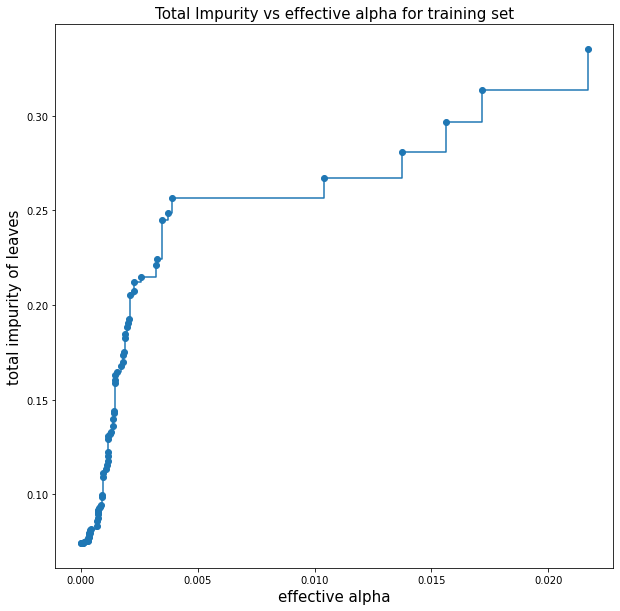

In [54]:
dt_alpha = DecisionTreeClassifier(random_state=0,  class_weight = {0: 1.3, 1: 0.7})
path = dt_alpha.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

fig, ax = plt.subplots(figsize = (10,10))
ax.plot(ccp_alphas[:-1], impurities[:-1], marker='o', drawstyle="steps-post")
ax.set_xlabel("effective alpha", fontsize=15)
ax.set_ylabel("total impurity of leaves", fontsize=15)
ax.set_title("Total Impurity vs effective alpha for training set", fontsize=15)

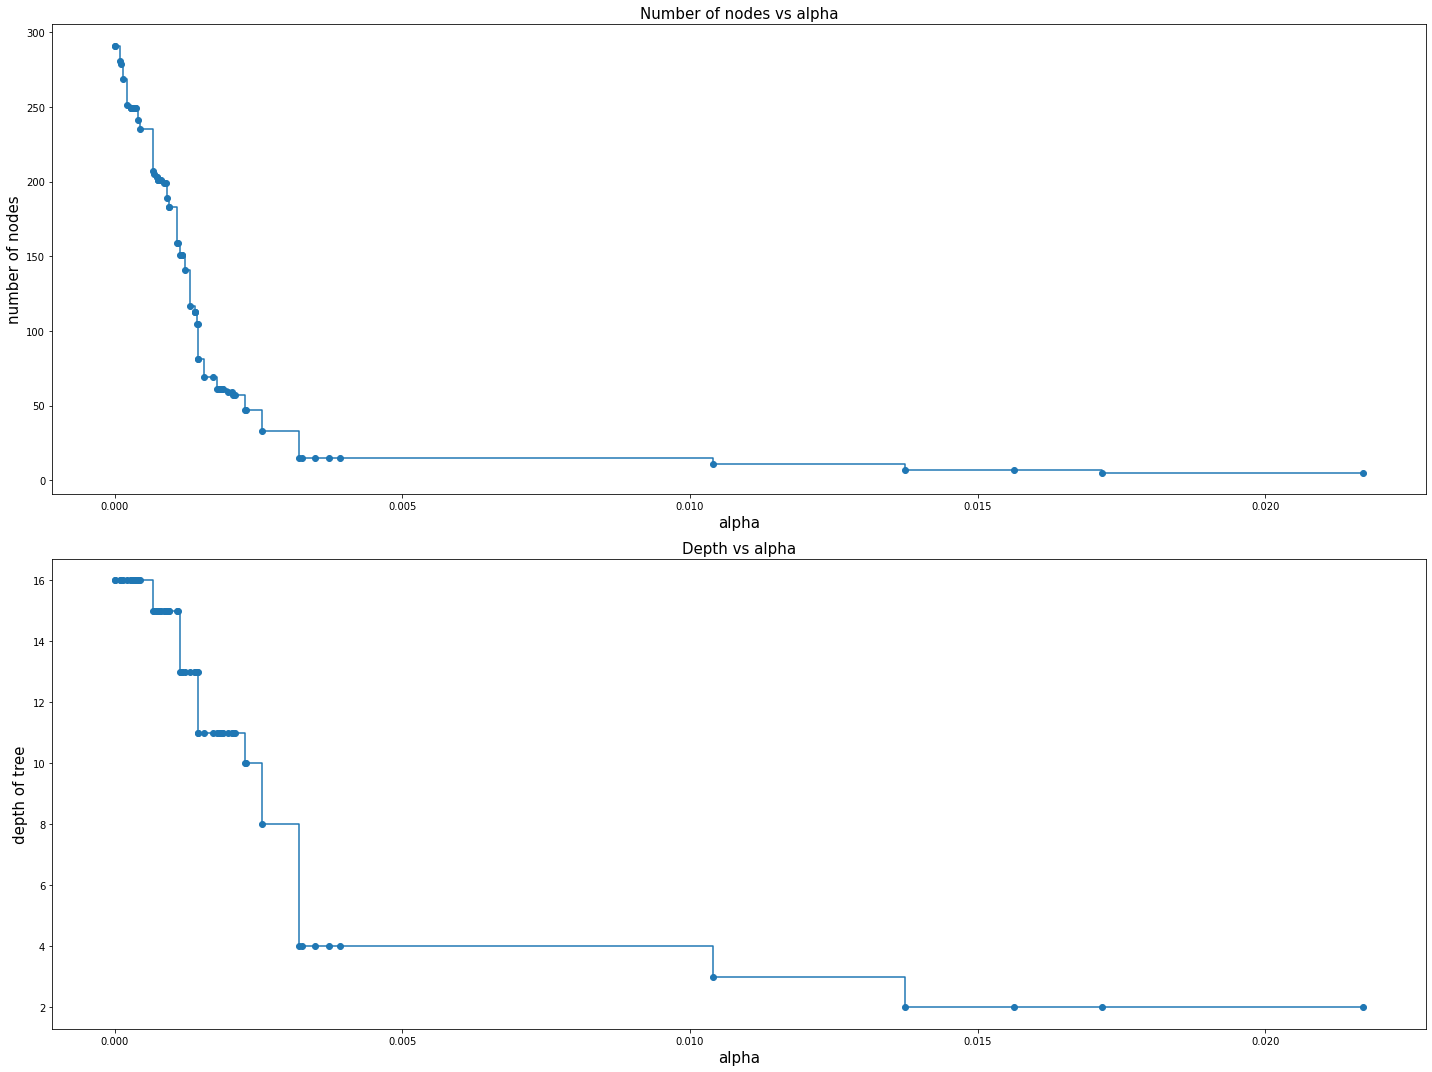

In [55]:
trees = []
for ccp_alpha in ccp_alphas:
    dt_alpha = DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alpha).fit(X_train, y_train)
    trees.append(dt_alpha)

trees = trees[:-1]
ccp_alphas = ccp_alphas[:-1]

node_counts = [tree.tree_.node_count for tree in trees]
depth = [tree.get_depth() for tree in trees]

fig, ax = plt.subplots(2, 1, figsize=(20, 15))
ax[0].plot(ccp_alphas, node_counts, marker='o', drawstyle="steps-post")
ax[0].set_xlabel("alpha", fontsize=15)
ax[0].set_ylabel("number of nodes", fontsize=15)
ax[0].set_title("Number of nodes vs alpha", fontsize=15)
ax[1].plot(ccp_alphas, depth, marker='o', drawstyle="steps-post")
ax[1].set_xlabel("alpha", fontsize=15)
ax[1].set_ylabel("depth of tree", fontsize=15)
ax[1].set_title("Depth vs alpha", fontsize=15)
fig.tight_layout()

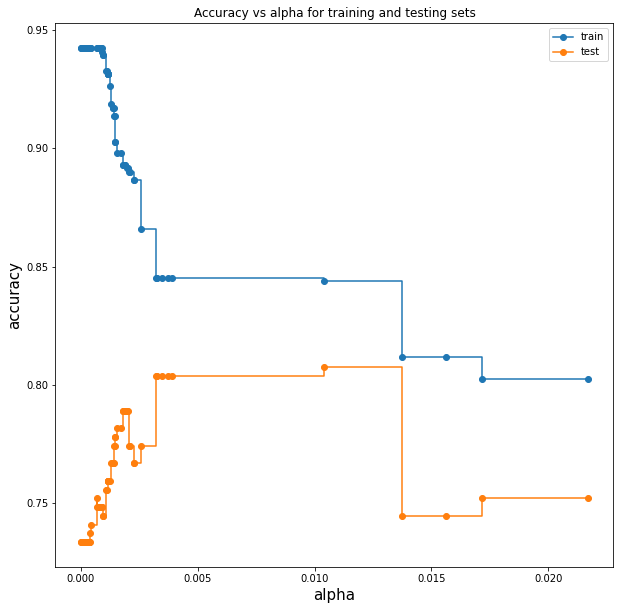

In [56]:
train_scores = [tree.score(X_train, y_train) for tree in trees]
val_scores = [tree.score(X_val, y_val) for tree in trees]

fig, ax = plt.subplots(figsize = (10,10))
ax.set_xlabel("alpha", fontsize=15)
ax.set_ylabel("accuracy", fontsize=15)
ax.set_title("Accuracy vs alpha for training and testing sets")
ax.plot(ccp_alphas, train_scores, marker='o', label="train", drawstyle="steps-post")
ax.plot(ccp_alphas, val_scores, marker='o', label="test", drawstyle="steps-post")
ax.legend()
plt.show()

In [57]:
index_best_model = np.argmax(val_scores)
best_model = trees[index_best_model]
print('ccp_alpha of best model: ',trees[index_best_model])
print('_____________________')
print('Training accuracy of best model: ',best_model.score(X_train, y_train))
print('Test accuracy of best model: ',best_model.score(X_val, y_val))

ccp_alpha of best model:  DecisionTreeClassifier(ccp_alpha=0.010404808266030385, class_weight=None,
                       criterion='gini', max_depth=None, max_features=None,
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       presort='deprecated', random_state=0, splitter='best')
_____________________
Training accuracy of best model:  0.8437001594896332
Test accuracy of best model:  0.8074074074074075


In [58]:
dt = DecisionTreeClassifier(ccp_alpha=0.010404808266030385).fit(scaler_X_train, y_train)

In [59]:
labels_train_dt = dt.predict(scaler_X_train)
accuracy_score(y_train, labels_train_dt)

0.8437001594896332

In [60]:
labels_val_dt = dt.predict(scaler_X_val)
accuracy_score(y_val, labels_val_dt)

0.8074074074074075

<hr>
<a class="anchor" id="pa">

### 4.1.5. Passive Aggressive
    
</a>

In [61]:
# pa_clf = PassiveAggressiveClassifier(random_state=15)

# pa_parameters = {"warm_start" : [True, False],
#                  "early_stopping" : [True, False],
#                  "max_iter" : (100, 500, 1000),
#                  "class_weight" : ['balanced', None]}

# pa_grid = GridSearchCV(estimator=pa_clf, param_grid=pa_parameters, cv=cv, scoring='accuracy', verbose=1, n_jobs=-1)

# pa_grid.fit(scaler_X_train, y_train)
# pa_grid.best_params_

In [62]:
pa = PassiveAggressiveClassifier(class_weight=None, early_stopping=False, max_iter=100, warm_start=True,
                                 random_state=15)
pa.fit(scaler_X_train, y_train)

PassiveAggressiveClassifier(C=1.0, average=False, class_weight=None,
                            early_stopping=False, fit_intercept=True,
                            loss='hinge', max_iter=100, n_iter_no_change=5,
                            n_jobs=None, random_state=15, shuffle=True,
                            tol=0.001, validation_fraction=0.1, verbose=0,
                            warm_start=True)

In [63]:
labels_train_pa = pa.predict(scaler_X_train)
accuracy_score(y_train, labels_train_pa)

0.5550239234449761

In [64]:
labels_val_pa = pa.predict(scaler_X_val)
accuracy_score(y_val, labels_val_pa)

0.5111111111111111

<hr>
<a class="anchor" id="logreg">

### 4.1.6. Logistic Regression
    
</a>

In [65]:
# log_clf = LogisticRegression()

# log_parameters = {'solver': ['newton-cg', 'sag', 'saga', 'lbfgs'],
#                   'warm_start' : [True, False],
#                   'max_iter' : (100, 200, 300)}

# log_grid = GridSearchCV(estimator=log_clf, param_grid=log_parameters, cv=cv, scoring='accuracy', verbose=1, n_jobs=-1)
# log_grid.fit(scaler_X_train, y_train)
# log_grid.best_params_

In [66]:
log = LogisticRegression(class_weight={0: 0.8, 1: 1.1999999999999997},
                         max_iter=700, penalty='l1', random_state=15, 
                         solver='liblinear', tol=1e-05, verbose=0, warm_start=True).fit(scaler_X_train, y_train) 

In [67]:
labels_train_log = log.predict(scaler_X_train)
accuracy_score(y_train, labels_train_log)

0.8181818181818182

In [68]:
labels_val_log = log.predict(scaler_X_val)
accuracy_score(y_val, labels_val_log)

0.7925925925925926

<hr>
<a class="anchor" id="mlp">

### 4.1.7. Multi-Layer Perceptron
    
</a>

In [69]:
def combination_layers(min_neurons,max_neurons,n_layers): 
    l = []
    for i in range(min_neurons,max_neurons):
        l.append(i)
    layersize = list(combinations_with_replacement(l,n_layers))
    return layersize

In [70]:
# mlp = MLPClassifier(random_state=15)

# mlp_parameters = {
#     'hidden_layer_sizes': combination_layers(10,50,3),
#     'activation': ['identity','logistic','tanh', 'relu'],
#     'tol' : list(np.linspace(0.00001,0.001,3)),
#     'learning_rate': ['constant','adaptive'],
#     'solver' : ['lbfgs', 'sgd', 'adam'],
#     'beta_1': list(np.linspace(0.001,0.1,20)),
#     'beta_2': list(np.linspace(0.001,0.1,20)),
#     'alpha': list(np.linspace(0.001,0.1,20)),
#     'learning_rate_init': list(np.linspace(0.1,1,20))
# }

# mlp_grid = GridSearchCV(estimator=mlp, param_grid=mlp_parameters, cv=cv, scoring='accuracy', verbose=1, n_jobs=-1)
# mlp_grid.fit(scaler_X_train, y_train)
# mlp_grid.best_params_

In [71]:
mlp = MLPClassifier(random_state=15,
                    hidden_layer_sizes = (14,18,18),
                    max_iter=700,
                    activation='relu',
                    solver='adam',
                    tol = 0.000505, 
                    learning_rate='constant',
                    early_stopping = False,
                    warm_start = True).fit(scaler_X_train,y_train)

In [72]:
labels_train_mlp = mlp.predict(scaler_X_train)
accuracy_score(y_train, labels_train_mlp)

0.84688995215311

In [73]:
labels_val_mlp = mlp.predict(scaler_X_val)
accuracy_score(y_val, labels_val_mlp)

0.8074074074074075

<hr>
<a class="anchor" id="naive">

### 4.1.8. Naive Bayes
    
</a>

In [74]:
nb = GaussianNB().fit(scaler_X_train, y_train)

In [75]:
labels_train_nb = nb.predict(scaler_X_train)
accuracy_score(y_train, labels_train_nb)

0.8022328548644339

In [76]:
labels_val_nb = nb.predict(scaler_X_val)
accuracy_score(y_val, labels_val_nb)

0.7703703703703704

<hr>
<a class="anchor" id="svm">

### 4.1.9. Support Vector Machine (SVM)
    
</a>

In [77]:
# svm_weights = ['balanced']
# for i in  np.arange(0.6,1.1,0.1):
#     for j in  np.arange(0.9,1.1,0.1):
#         svm_weights.append({0:i,1:j})

In [78]:
# svm_clf = SVC(random_state=15, decision_function_shape = 'ovr')

# svm_parameters = {
#     'kernel' : ['poly'],
#     'tol' : list(np.linspace(0.000001,0.00005,10)),
#     'degree': [2, 3, 4],
#     'gamma' : ['scale', 'auto'],
#     'class_weight' : svm_weights,
#     'C' : np.arange(11, 30, 2)
# }


# svm_grid = GridSearchCV(estimator= svm_clf, param_grid=svm_parameters, cv = cv, scoring='accuracy', verbose=1, n_jobs=-1)
# svm_grid.fit(scaler_X_train, y_train)
# print("Best Score: ", svm_grid.best_score_)
# print("Best MLP: ", svm_grid.best_estimator_)

In [79]:
svm = SVC(C=11, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
          decision_function_shape='ovr', degree=2, gamma='scale', kernel='poly',
          max_iter=-1, probability=False, random_state=15, shrinking=True, tol=1e-06,
          verbose=False).fit(scaler_X_train, y_train)

In [80]:
labels_train_svm = svm.predict(scaler_X_train)
accuracy_score(y_train, labels_train_svm)

0.8389154704944178

In [81]:
labels_val_svm = svm.predict(scaler_X_val)
accuracy_score(y_val, labels_val_svm)

0.8074074074074075

<hr>
<a class="anchor" id="ensemble">

## 4.1.10. Ensemble 
    
</a>

In order to enhance the performance of the model, ensemble was implemented. The main goal is to provide the ability to combine conceptually different machine learning classifiers into one single classifier, boosting their individual performance and tackling their individual weaknesses. 

There are three different approaches to reach this goal, namely, bagging, boosting and stacking. Bagging tries to create new diverse models by changing or duplicating the observations and/or features used. On the other hand, boosting uses weak learners, that performs just slightly better than random guessing and tries to “boost” its performance into a strong learning algorithm in a set of iterative trainings. Lastly, while bagging and boosting uses homogeneous weak learners, stacking uses heterogeneous weak learners and applies a meta-learner algorithm instead of voting to combine the predictions of base learners.

<hr>
<a class="anchor" id="bbc">

### 4.1.10.1. Balanced Bagging Classifier
    
</a>

In [82]:
# bbc_clf = BalancedBaggingClassifier()

# bbc_parameters = {'base_estimator' : [None, knn, knc, rf, dt, pa, log, mlp, nb, svm],
#                   'n_estimators' : np.arange(10,60,10),
#                   'bootstrap' : [True, False],
#                   'bootstrap_features' : [True, False],
#                   'warm_start' : [True, False],
#                   'sampling_strategy' : ['not majority', 'not minority', 'all', 'majority', 'minority'],
#                   'replacement' : [True, False]}

# bbc_grid = GridSearchCV(estimator=bbc_clf, param_grid=bbc_parameters, cv=cv, scoring='accuracy', verbose=1, n_jobs=-1)
# bbc_grid.fit(scaler_X_train, y_train)
# bbc_grid.best_params_

In [83]:
bb = BalancedBaggingClassifier(base_estimator=dt, n_estimators=10, bootstrap=True, bootstrap_features=True,
                               sampling_strategy='majority', replacement=True, 
                               warm_start=True, random_state=15).fit(scaler_X_train, y_train)

In [84]:
labels_train_bb = bb.predict(scaler_X_train)
accuracy_score(y_train, labels_train_bb)

0.8277511961722488

In [85]:
labels_val_bb = bb.predict(scaler_X_val)
accuracy_score(y_val, labels_val_bb)

0.7888888888888889

<hr>
<a class="anchor" id="gbc">

### 4.1.10.2. Gradient Boosting Classifier
    
</a>

In [86]:
# GB_clf = GradientBoostingClassifier()

# GB_parameters = {'loss' : ['deviance', 'exponential'],
#                  'learning_rate' : (0.01, 0.1, 1),
#                  'n_estimators' : np.arange(100, 400, 100),
#                  'max_depth' : (5, 10, 15, 20, 30),
#                  'max_features' : ['auto', 'log2', None],
#                  'warm_start' : [True, False]}

# GB_grid = GridSearchCV(estimator=GB_clf, param_grid=GB_parameters, cv=cv, scoring='accuracy', verbose=1, n_jobs=-1)
# GB_grid.fit(scaler_X_train , y_train)
# GB_grid.best_params_

In [88]:
gb = GradientBoostingClassifier(learning_rate=0.01, loss='deviance', max_depth=4, max_features='log2',
                               n_estimators=300, random_state=15)
gb.fit(scaler_X_train, y_train)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.01, loss='deviance', max_depth=4,
                           max_features='log2', max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=300,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=15, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [89]:
labels_train_gb = gb.predict(scaler_X_train)
accuracy_score(y_train, labels_train_gb)

0.8644338118022329

In [90]:
labels_val_gb = gb.predict(scaler_X_val)
accuracy_score(y_val, labels_val_gb)

0.7888888888888889

<hr>
<a class="anchor" id="adaboost">

### 4.1.10.3. AdaBoost Classifier
    
</a>

In [ ]:
# AdaBoost = AdaBoostClassifier()

# AdaBoost_parameters = {'base_estimator' : [None, dt, rf, log, nb, svm],
#                        'n_estimators' : np.arange(40, 105, 5),
#                        'learning_rate' : (0.01, 0.1, 1, 10),
#                        'algorithm' : ['SAMME', 'SAMME.R']}

# AdaBoost_grid = GridSearchCV(estimator=AdaBoost, param_grid=AdaBoost_parameters, cv=cv, 
#                              scoring='accuracy', verbose=1, n_jobs=-1)

# AdaBoost_grid.fit(scaler_X_train , y_train)
# AdaBoost_grid.best_params_

In [91]:
AdaBoost = AdaBoostClassifier(base_estimator=rf, n_estimators=95, learning_rate=0.01, 
                              algorithm='SAMME', random_state=15)
AdaBoost.fit(scaler_X_train,y_train)

AdaBoostClassifier(algorithm='SAMME',
                   base_estimator=RandomForestClassifier(bootstrap=True,
                                                         ccp_alpha=0.004,
                                                         class_weight={0: 1.1800000000000002,
                                                                       1: 1.0300000000000002},
                                                         criterion='gini',
                                                         max_depth=None,
                                                         max_features='auto',
                                                         max_leaf_nodes=None,
                                                         max_samples=None,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=1,
    

In [92]:
labels_train_AdaBoost = AdaBoost.predict(scaler_X_train)
accuracy_score(y_train, labels_train_AdaBoost)

0.8899521531100478

In [93]:
labels_val_AdaBoost = AdaBoost.predict(scaler_X_val)
accuracy_score(y_val, labels_val_AdaBoost)

0.7851851851851852

<hr>
<a class="anchor" id="vc">

### 4.1.10.4. Voting Classifier
    
</a>

In [94]:
vc = VotingClassifier(estimators=[('rf', rf), ('log', log), ('dt', dt), ('mlp', mlp), ('AdaBoost', AdaBoost)])
vc.fit(scaler_X_train, y_train)

VotingClassifier(estimators=[('rf',
                              RandomForestClassifier(bootstrap=True,
                                                     ccp_alpha=0.004,
                                                     class_weight={0: 1.1800000000000002,
                                                                   1: 1.0300000000000002},
                                                     criterion='gini',
                                                     max_depth=None,
                                                     max_features='auto',
                                                     max_leaf_nodes=None,
                                                     max_samples=None,
                                                     min_impurity_decrease=0.0,
                                                     min_impurity_split=None,
                                                     min_samples_leaf=1,
                                                     m

In [95]:
labels_train_vc = vc.predict(scaler_X_train)
accuracy_score(y_train, labels_train_vc)

0.8532695374800638

In [96]:
labels_val_vc = vc.predict(scaler_X_val)
accuracy_score(y_val, labels_val_vc)

0.8037037037037037

<hr>
<a class="anchor" id="stack">

### 4.1.10.5. Stacking Classifier
    
</a>

In [97]:
sc = StackingClassifier(estimators=[('knn', knn), ('rf', rf), ('log', log), ('dt', dt), ('nb', nb)], 
                        final_estimator=vc).fit(scaler_X_train, y_train)

In [98]:
labels_train_sc = sc.predict(scaler_X_train)
accuracy_score(y_train, labels_train_sc)

0.8548644338118022

In [99]:
labels_val_sc = sc.predict(scaler_X_val)
accuracy_score(y_val, labels_val_sc)

0.8037037037037037

<hr>
<a class="anchor" id="finalmodel">

## 4.2 Final Model
    
</a>

In this section, we produced the best final model according to the accuracy score provided from kaggle test set, once our final goal is to reach a generable model, capable of correctly predict unseen data.

Additionally, the remaining models selected on kaggle are commented in this section. Nevertheless, in the end, there is a visual performance comparison between these top 5 models.

<hr>
<a class="anchor" id="keras">

## 4.2.1. Neural Network Keras
    
</a>

In [100]:
y_train_array = np.asarray(y_train).astype('float32')
y_val_array = np.asarray(y_val).astype('float32')

In [148]:
model = models.Sequential()
model.add(layers.Dense(14, activation='relu', kernel_regularizer=regularizers.l2(0.001), input_dim=6))
model.add(layers.Dropout(0.1))
model.add(layers.Dense(18, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(layers.Dropout(0.1))
model.add(layers.Dense(18, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(layers.Dropout(0.1))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

callbacks_list = [keras.callbacks.EarlyStopping(monitor='accuracy',
                                                patience=5),
                  keras.callbacks.ModelCheckpoint(filepath='my_model.h5',
                                                  monitor='val_accuracy',
                                                  save_best_only=True)]

history = model.fit(scaler_X_train, y_train_array, epochs=100, 
                    validation_data=(scaler_X_val, y_val_array),
                    callbacks=callbacks_list)

Train on 627 samples, validate on 270 samples
Epoch 1/100
627/627 [==============================] - 0s 528us/step - loss: 0.7153 - accuracy: 0.6156 - val_loss: 0.6974 - val_accuracy: 0.7074
Epoch 2/100
627/627 [==============================] - 0s 53us/step - loss: 0.6806 - accuracy: 0.7209 - val_loss: 0.6634 - val_accuracy: 0.7556
Epoch 3/100
627/627 [==============================] - 0s 62us/step - loss: 0.6472 - accuracy: 0.7512 - val_loss: 0.6256 - val_accuracy: 0.7593
Epoch 4/100
627/627 [==============================] - 0s 66us/step - loss: 0.6111 - accuracy: 0.7624 - val_loss: 0.5894 - val_accuracy: 0.7556
Epoch 5/100
627/627 [==============================] - 0s 66us/step - loss: 0.5647 - accuracy: 0.7847 - val_loss: 0.5564 - val_accuracy: 0.7667
Epoch 6/100
627/627 [==============================] - 0s 55us/step - loss: 0.5415 - accuracy: 0.8006 - val_loss: 0.5340 - val_accuracy: 0.7741
Epoch 7/100
627/627 [==============================] - 0s 51us/step - loss: 0.5254 - accu

`NOTE: ` Keras do not provide a random state, therefore results may vary from each run. Nevertheless, the exported version was able to reach an accuracy score of 0.8111 in the validation set.

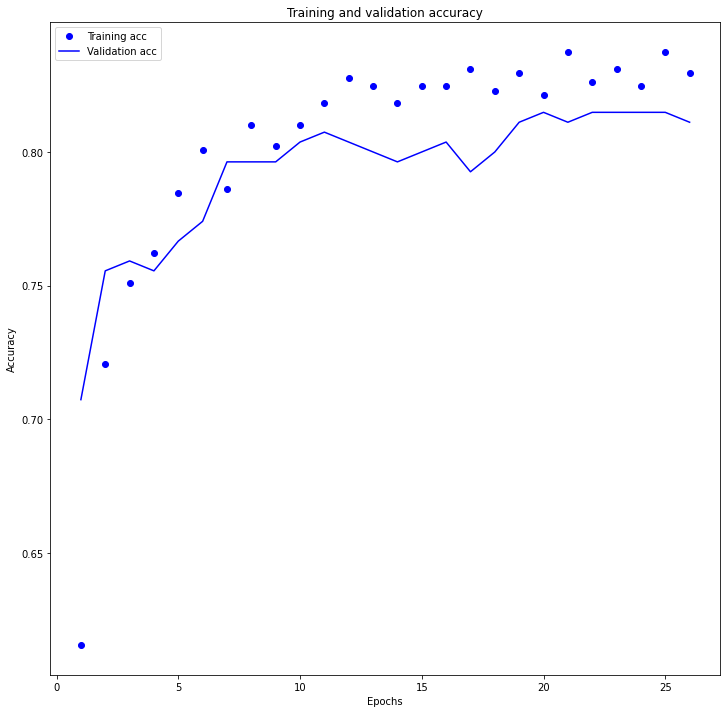

In [149]:
plt.clf()
history_dict = history.history
acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']

epochs = range(1, len(history_dict['accuracy'])+1)

plt.plot(epochs, acc_values, 'bo', label='Training acc')
plt.plot(epochs, val_acc_values, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [150]:
acc_train = model.evaluate(scaler_X_train, y_train_array)
acc1_train = acc_train[1]

627/627 [==============================] - 0s 19us/step


In [151]:
acc = model.evaluate(scaler_X_val, y_val_array)
acc1 = acc[1]

270/270 [==============================] - 0s 31us/step


In [152]:
labels_train_keras = model.predict(scaler_X_train)

labels_train_bin = []
for i in labels_train_keras:
    if i > 0.5:
        labels_train_bin.append(1)
    else:
        labels_train_bin.append(0)

In [153]:
labels_val_keras = model.predict(scaler_X_val)

labels_val_bin = []
for i in labels_val_keras:
    if i > 0.5:
        labels_val_bin.append(1)
    else:
        labels_val_bin.append(0)

In [154]:
labels_test_keras = model.predict(scaler_X_test)

labels_test_bin = []
for i in labels_test_keras:
    if i > 0.5:
        labels_test_bin.append(1)
    else:
        labels_test_bin.append(0)

<hr>
<a class="anchor" id="keras">

## 4.2.2. Neural Network sklearn 15 hidden units
    
</a>

In [155]:
mlp1 = MLPClassifier(activation='relu', alpha=0.025, batch_size='auto', beta_1=0.9, 
                     beta_2=0.999, early_stopping=False, epsilon=1e-08,        
                     hidden_layer_sizes=(15,), learning_rate='constant',   
                     learning_rate_init=0.025007500000000002, max_fun=15000, 
                     max_iter=800, momentum=0.9, n_iter_no_change=10,      
                     nesterovs_momentum=True, power_t=0.5, random_state=15,   
                     shuffle=True, solver='adam', tol=0.000505,         
                     validation_fraction=0.1, verbose=False, warm_start=True).fit(scaler_X_train, y_train)

In [156]:
labels_train_mlp1 = mlp1.predict(scaler_X_train)
acc2_train = accuracy_score(y_train, labels_train_mlp1)

In [157]:
labels_val_mlp1 = mlp1.predict(scaler_X_val)
acc2 = accuracy_score(y_val, labels_val_mlp1)

<hr>
<a class="anchor" id="keras">

## 4.2.3. Neural Network sklearn 10 hidden units
    
</a>

In [158]:
mlp2 = MLPClassifier(activation='relu', alpha=0.032, batch_size='auto', beta_1=0.9,    
                      beta_2=0.999, early_stopping=False, epsilon=1e-08,    
                      hidden_layer_sizes=(10,), learning_rate='constant', 
                      learning_rate_init=0.025007500000000002, max_fun=15000,   
                      max_iter=800, momentum=0.9, n_iter_no_change=10,           
                      nesterovs_momentum=True, power_t=0.5, random_state=15,  
                      shuffle=True, solver='adam', tol=0.000505,         
                      validation_fraction=0.1, verbose=False, warm_start=True).fit(scaler_X_train, y_train)

In [159]:
labels_train_mlp2 = mlp2.predict(scaler_X_train)
acc3_train = accuracy_score(y_train, labels_train_mlp1)

In [160]:
labels_val_mlp2 = mlp2.predict(scaler_X_val)
acc3 = accuracy_score(y_val, labels_val_mlp2)

<hr>
<a class="anchor" id="stackingclf">

## 4.2.4. Ensemble - Stacking Classifier
    
</a>

In [161]:
SC = StackingClassifier(estimators=[('mlp', mlp),('dt',dt)], final_estimator=LogisticRegression(), 
                        stack_method = 'predict').fit(scaler_X_train, y_train)

In [162]:
labels_train_sc = SC.predict(scaler_X_train)
acc4_train = accuracy_score(y_train, labels_train_sc)

In [163]:
labels_val_sc = SC.predict(scaler_X_val)
acc4 = accuracy_score(y_val, labels_val_sc)

<hr>
<a class="anchor" id="sklearn2h">

## 4.2.5. Neural Network sklearn 2 hidden layers
    
</a>

In [164]:
mlp3 = MLPClassifier(hidden_layer_sizes = (10,34), random_state = 15, warm_start = True, early_stopping=False,          
                     max_iter = 5000, activation ='relu', learning_rate = 'constant',
                     tol = 1e-05, solver = 'adam').fit(scaler_X_train, y_train)

In [165]:
labels_train_mlp3 = mlp3.predict(scaler_X_train)
acc5_train = accuracy_score(y_train, labels_train_mlp3)

In [166]:
labels_val_mlp3 = mlp3.predict(scaler_X_val)
acc5 = accuracy_score(y_val, labels_val_mlp3)

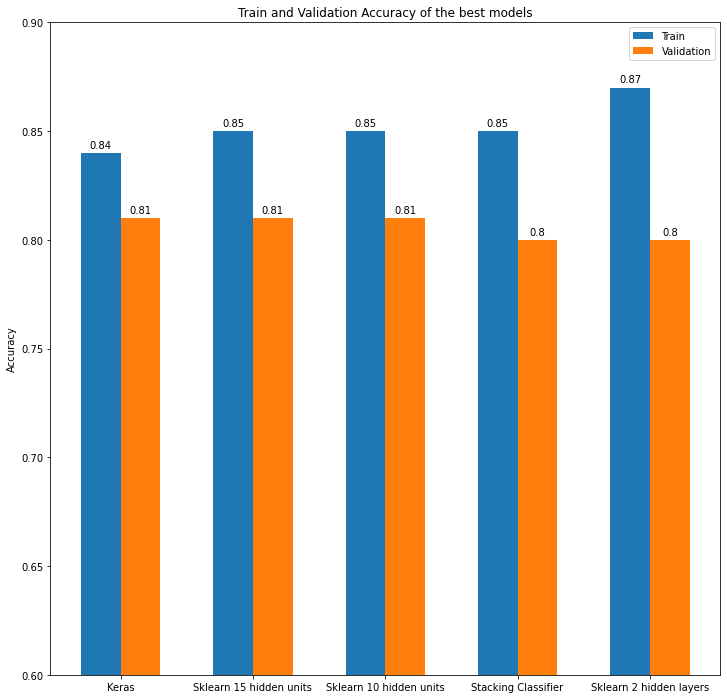

In [167]:
BestModels_train_accuracy = np.round([acc1_train, acc2_train, acc3_train, acc4_train, acc5_train], 2)
BestModels_val_accuracy = np.round([acc1, acc2, acc3, acc4, acc5], 2)
labels = ['Keras', 'Sklearn 15 hidden units', 'Sklearn 10 hidden units', 'Stacking Classifier', 'Sklearn 2 hidden layers']

x = np.arange(len(labels))
width = 0.3

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, BestModels_train_accuracy, width, label='Train')
rects2 = ax.bar(x + width/2, BestModels_val_accuracy, width, label='Validation')

ax.set_ylabel('Accuracy')
ax.set_title('Train and Validation Accuracy of the best models')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects1)
autolabel(rects2)
plt.ylim(0.6,0.9)

#fig.tight_layout()

plt.show()

Concerning the model selection and after testing all the algorithms presented above with the correspondent grid search, we arise to a set of models that provide the overall best results. Even though algorithms like decision trees or random forest as well as ensembles tend to achieve better results in the validation dataset, we find that these are often unreliable and are likely to overfit when tested on our final dataset. Therefore, we opted for the most consistent algorithm across all partitions and selected the Multi-layer Perceptron as the more reliable algorithm. Bearing this in mind, more time and resources were spent trying to adjust the hyperparameters of this algorithm and this was often chosen as base estimator across the ensemble techniques. Complementary we also implemented Neural Networks with the help of _Keras_ library to explore further parameters and determine if we could obtain better results.

<hr>
<a class="anchor" id="assess">

# 5. Assess
    
</a>

In this step is possible to analyze the detailed results for the final model presented before concerning the precision, recall, f1-score and accuracy metrics. It is important to compare the results of the train and validation sets to guarantee that our model is not overfitting and therefore is capable of generalizing their results.

In [168]:
model = model
labels_train = labels_train_bin
labels_val = labels_val_bin

In [169]:
def metrics(y_train, pred_train , y_val, pred_val):
    print('___________________________________________________________________________________________________________')
    print('                                                     TRAIN                                                 ')
    print('-----------------------------------------------------------------------------------------------------------')
    print(classification_report(y_train, pred_train))
    print(confusion_matrix(y_train, pred_train))


    print('___________________________________________________________________________________________________________')
    print('                                                VALIDATION                                                 ')
    print('-----------------------------------------------------------------------------------------------------------')
    print(classification_report(y_val, pred_val))
    print(confusion_matrix(y_val, pred_val))
    
metrics(y_train, labels_train, y_val, labels_val)

___________________________________________________________________________________________________________
                                                     TRAIN                                                 
-----------------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.86      0.69      0.76       240
           1       0.83      0.93      0.88       387

    accuracy                           0.84       627
   macro avg       0.84      0.81      0.82       627
weighted avg       0.84      0.84      0.83       627

[[165  75]
 [ 27 360]]
___________________________________________________________________________________________________________
                                                VALIDATION                                                 
-----------------------------------------------------------------------------------------------------------
  

In [172]:
submission_test = pd.DataFrame()
submission_test['Patient_ID'] = test_df.index
submission_test['Deceased'] = labels_test_bin
version = 28
path = r'/Users/davidsousa/Documents/GitHub/ML/Data/Group38_version' + str(version) + '.csv'
submission_test.to_csv(path, index = False)

In [173]:
submission_test.Deceased.value_counts()

1    275
0    125
Name: Deceased, dtype: int64

<hr>
<a class="anchor" id="limitations">

# 6. Limitations
    
</a>

The results shown before were obtained through the exploration of an exhaustive set of combinations of parameters and algorithms that could be certainly improved given the increase in resources such as time and computational power. Even though we consider our results to be adequate to the challenge proposed, it would be interesting to try a broader set of parameters and a wider range of algorithms.

Furthermore, one of the greatest limitations that we felt throughout the project was the size of the dataset. Said that, possessing only 900 rows and 10 independent variables, from which only one was continuous, the type of possible transformations to perform were very limited. Also, after spliting the data into train and validation partitions, we ended up with only 70% of the data (around 630 rows) to train our model which is far from an ideal scenario, specially if we consider using cross-validation for more robust results. Therefore, it was necessary to weight the pros and cons of having a small training and validation sets in order to ensure that our final model did not suffer from neither overfitting or underfitting.

<hr>
<a class="anchor" id="conclusion">

# 7. Conclusion
    
</a>

In the elaboration of this project our team was faced with a lot of challenges not only because of the nature of data in hands but also with the need to choose the most appropriate method or algorithm for each step. 

The data preparation and preprocessing were an essential phase of the project because the quality of the final dataset will influence all the following analysis. In this phase we were very thorough in analyzing all the outliers as well as treating the missing values with all the techniques necessary to maintain the consistency and coherence of the original data without losing too much information. Furthermore, the data partition was tested repeatedly with different sets of variables based on the analysis of the feature selection methods and the accuracy obtained, not only, in the validation set, but also in the test set. 

Subsequently we started by training our model by using algorithms such as Decision Trees, Logistic Regressions, Multi-layer Perceptrons, Recurrent Neural Networks, Support Vector Machines, different ensemble methods, and others, until we reach a final prediction that allows to achieve the maximum accuracy possible, based on the 30% of the test dataset, we can assess on kaggle. This is likely the most important stage of this project and therefore was also the one in which we spent the most time.

Finally, we decided which were the 5 models in which we would like to predict the 100% of the test set. This was the last but, probably, the most important step of our project, because our main objective is to perform well on the unseen data and for that, not only the accuracy matters, but also diversity between the 5 chosen models.